In [58]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from os import listdir, getcwd
from os.path import isfile, join, dirname
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [59]:
#Read in Input Path Where Datafiles are Stored, keep as a list of files
try:
    input_path = dirname(getcwd()) + "\\Data\\Test_Data\\"
    onlyfiles = [f for f in listdir(input_path) if isfile(join(input_path, f))]
except Exception as e:
    print("Error Reading in Dataset Files, Check Input Path")
    print(e)
else:
    print("Dataset Files Loaded In")

#Read in Each File and Store it into One Large Dataframe, Skipping Files that Don't Contain 'SEQN' Column
try:
    df_init = pd.DataFrame()
    i = 0
    for filename in onlyfiles:
        if i == 0:
            df_init = pd.read_sas(input_path + filename) 
            i+=1
        else: 
            df_next = pd.read_sas(input_path + filename)
            if 'SEQN' not in df_next:
                print(filename + " does not have 'SEQN' column, skipping this file")
                i+=1
                next
            else:
                df_init = pd.merge(df_init,df_next,how = 'outer', on = 'SEQN')
                i+=1
except Exception as e:
    print("Error Loading in Data")
    print(e)
else:
    print("Datasets Merged into One Dataframe")
    
#MCQ220 - Have you been diagnosed with cancer
#MCQ230a -What kind was it

#Identify Response Variable Column, And Begin Dataframe Cleaning
response = "MCQ220"

df_init

Dataset Files Loaded In
RXQ_DRUG.xpt does not have 'SEQN' column, skipping this file
Datasets Merged into One Dataframe


,SEQN,ACD011A,ACD011B,ACD011C,ACD040,ACD110,ALQ111,ALQ121,ALQ130,ALQ142,...,WHD080U,WHD080L,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ190,WHQ200
0,93705.0,1.0,NaN,NaN,NaN,NaN,1.0,7.0,1.0,5.397605e-79,...,NaN,NaN,4.0,150.0,130.0,63.0,170.0,62.0,2.0,NaN
1,93705.0,1.0,NaN,NaN,NaN,NaN,1.0,7.0,1.0,5.397605e-79,...,NaN,NaN,4.0,150.0,130.0,63.0,170.0,62.0,2.0,NaN
2,93705.0,1.0,NaN,NaN,NaN,NaN,1.0,7.0,1.0,5.397605e-79,...,NaN,NaN,4.0,150.0,130.0,63.0,170.0,62.0,2.0,NaN
3,93706.0,NaN,NaN,NaN,NaN,4.0,2.0,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,150.0,17.0,2.0,NaN
4,93707.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19638,102862.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19639,102919.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19640,102927.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19641,102928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#Exclude Object Columns and Drop Duplicates
df_init = df_init.select_dtypes(exclude=['object'])
df_init = df_init.drop_duplicates(subset = 'SEQN', keep = 'last')

#Exclude C Columns
df_init = df_init.loc[:, ~df_init.columns.str.endswith('C')].round()


In [61]:
#Keep Only Rows that Have Response Variable
df_init_1 = df_init[df_init[response].notna()]

#Drop Columns With More than 30% of Rows Missing

perc = 30 # Like N %
min_count =  int(((100-perc)/100)*df_init_1.shape[0] + 1)
df_init_2 = df_init_1.dropna( axis=1, 
                thresh=min_count)

#Impute Missing Values with Median of Column

df_init_3 = df_init_2.fillna(df_init_2.median())

#Scale the Dataset
scaler = preprocessing.StandardScaler().fit(df_init_3)
scaled_data = scaler.transform(df_init_3)

#Remove Outliers with one_class_SVM

# identify 5% of data as outliers in the training dataset
ee = OneClassSVM(nu = .10)
yhat = ee.fit_predict(scaled_data)
mask = yhat != -1

# select all rows that are not outliers
df_init_4 = df_init_3[mask]

#Create Correlation Matrix and Remove Correlated Variables
corr_matrix = df_init_4.corr()

df_init_4

,SEQN,ALQ111,ALQ121,ALQ151,AUQ054,BPQ020,BPQ080,BPQ070,BPQ090D,WTDRD1_x,...,WHQ030,WHQ040,WHD050,WHQ070,WHQ225,WHD110,WHD120,WHD140,WHQ150,WHQ190
2,93705.0,1.0,7.0,2.0,2.0,1.0,2.0,2.0,2.0,7186.0,...,1.0,3.0,165.0,2.0,4.0,150.0,130.0,170.0,62.0,2.0
7,93708.0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,10826.0,...,3.0,3.0,118.0,2.0,5.0,118.0,100.0,120.0,40.0,2.0
11,93709.0,1.0,5.0,2.0,1.0,1.0,2.0,2.0,2.0,28219.0,...,1.0,2.0,190.0,2.0,3.0,170.0,160.0,200.0,50.0,2.0
12,93711.0,1.0,5.0,2.0,1.0,2.0,1.0,1.0,1.0,9098.0,...,2.0,3.0,142.0,2.0,5.0,142.0,148.0,152.0,33.0,2.0
14,93713.0,1.0,6.0,2.0,1.0,2.0,2.0,1.0,2.0,252847.0,...,3.0,3.0,168.0,2.0,5.0,190.0,170.0,195.0,45.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18745,102950.0,1.0,5.0,2.0,3.0,1.0,1.0,1.0,1.0,28219.0,...,1.0,2.0,185.0,2.0,5.0,160.0,145.0,200.0,45.0,2.0
18747,102952.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0,2.0,13813.0,...,3.0,3.0,117.0,2.0,5.0,117.0,120.0,120.0,23.0,2.0
18749,102953.0,1.0,6.0,2.0,1.0,2.0,1.0,1.0,2.0,50632.0,...,1.0,2.0,205.0,2.0,5.0,200.0,180.0,222.0,41.0,2.0
18750,102954.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,11081.0,...,3.0,3.0,180.0,2.0,5.0,145.0,120.0,180.0,38.0,2.0


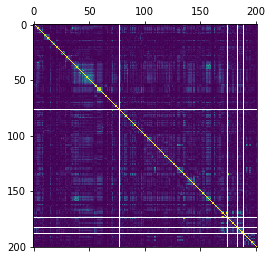

,SEQN,ALQ111,ALQ121,ALQ151,AUQ054,BPQ020,BPQ080,BPQ070,BPQ090D,WTDRD1_x,...,WHQ030,WHQ040,WHD050,WHQ070,WHQ225,WHD110,WHD120,WHD140,WHQ150,WHQ190
2,93705.0,1.0,7.0,2.0,2.0,1.0,2.0,2.0,2.0,7186.0,...,1.0,3.0,165.0,2.0,4.0,150.0,130.0,170.0,62.0,2.0
7,93708.0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,10826.0,...,3.0,3.0,118.0,2.0,5.0,118.0,100.0,120.0,40.0,2.0
11,93709.0,1.0,5.0,2.0,1.0,1.0,2.0,2.0,2.0,28219.0,...,1.0,2.0,190.0,2.0,3.0,170.0,160.0,200.0,50.0,2.0
12,93711.0,1.0,5.0,2.0,1.0,2.0,1.0,1.0,1.0,9098.0,...,2.0,3.0,142.0,2.0,5.0,142.0,148.0,152.0,33.0,2.0
14,93713.0,1.0,6.0,2.0,1.0,2.0,2.0,1.0,2.0,252847.0,...,3.0,3.0,168.0,2.0,5.0,190.0,170.0,195.0,45.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18745,102950.0,1.0,5.0,2.0,3.0,1.0,1.0,1.0,1.0,28219.0,...,1.0,2.0,185.0,2.0,5.0,160.0,145.0,200.0,45.0,2.0
18747,102952.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0,2.0,13813.0,...,3.0,3.0,117.0,2.0,5.0,117.0,120.0,120.0,23.0,2.0
18749,102953.0,1.0,6.0,2.0,1.0,2.0,1.0,1.0,2.0,50632.0,...,1.0,2.0,205.0,2.0,5.0,200.0,180.0,222.0,41.0,2.0
18750,102954.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,11081.0,...,3.0,3.0,180.0,2.0,5.0,145.0,120.0,180.0,38.0,2.0


In [62]:
import matplotlib.pyplot as plt

#Create Correlation Matrix and Remove Correlated Variables
corr_matrix = df_init_4.corr().abs()
corr_matrix

plt.matshow(corr_matrix)
plt.show()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.6)]

df_init_5 = df_init_4.drop(to_drop, axis=1)

df_init_5

In [63]:
# Calculate Variance Inflation Factor and Remove Variables with VIF Greater than 5

vif_data = pd.DataFrame()
vif_data["feature"] = df_init_5.columns
vif_data["VIF"] = [variance_inflation_factor(df_init_5.values, i) for i in range(len(df_init_5.columns))]

vif_removal = vif_data[vif_data['VIF'] > 5] 

C:\Users\nlahanis\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [64]:
#Calculate Drop Columns Corresponding to VIF
vif_drop = vif_removal["feature"].values

df_init_6 = df_init_5.drop(vif_drop, axis=1)

df_init_6 = df_init_6.drop(['SEQN'], axis=1)

X = df_init_6.loc[:, df_init_6.columns != response]
y = df_init_6[response]


In [65]:
df_init_6

,ALQ111,ALQ121,ALQ151,AUQ054,BPQ020,BPQ080,BPQ070,BPQ090D,WTDRD1_x,CBD071,...,WHQ030,WHQ040,WHD050,WHQ070,WHQ225,WHD110,WHD120,WHD140,WHQ150,WHQ190
2,1.0,7.0,2.0,2.0,1.0,2.0,2.0,2.0,7186.0,100.0,...,1.0,3.0,165.0,2.0,4.0,150.0,130.0,170.0,62.0,2.0
7,2.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,10826.0,400.0,...,3.0,3.0,118.0,2.0,5.0,118.0,100.0,120.0,40.0,2.0
11,1.0,5.0,2.0,1.0,1.0,2.0,2.0,2.0,28219.0,240.0,...,1.0,2.0,190.0,2.0,3.0,170.0,160.0,200.0,50.0,2.0
12,1.0,5.0,2.0,1.0,2.0,1.0,1.0,1.0,9098.0,800.0,...,2.0,3.0,142.0,2.0,5.0,142.0,148.0,152.0,33.0,2.0
14,1.0,6.0,2.0,1.0,2.0,2.0,1.0,2.0,252847.0,500.0,...,3.0,3.0,168.0,2.0,5.0,190.0,170.0,195.0,45.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18745,1.0,5.0,2.0,3.0,1.0,1.0,1.0,1.0,28219.0,400.0,...,1.0,2.0,185.0,2.0,5.0,160.0,145.0,200.0,45.0,2.0
18747,1.0,0.0,2.0,1.0,2.0,2.0,1.0,2.0,13813.0,450.0,...,3.0,3.0,117.0,2.0,5.0,117.0,120.0,120.0,23.0,2.0
18749,1.0,6.0,2.0,1.0,2.0,1.0,1.0,2.0,50632.0,250.0,...,1.0,2.0,205.0,2.0,5.0,200.0,180.0,222.0,41.0,2.0
18750,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,11081.0,300.0,...,3.0,3.0,180.0,2.0,5.0,145.0,120.0,180.0,38.0,2.0


In [66]:
#Train Elastic Net Regression Model
a = np.linspace(.001, 1.0, num=100)
l = np.linspace(.001, 1.0, num =100)
X = df_init_6.loc[:, df_init_6.columns != response]
y = df_init_6[response]

#Define Model

el_net = ElasticNetCV(l1_ratio = l, alphas=a)
# fit model
el_net.fit(X, y)

#return  most important features as determined by elastic net
el_net_vars = np.argsort(abs(el_net.coef_))[::-1]

In [67]:
#from sklearn.metrics import accuracy_score

#Filter Columns List
df_init_7 = df_init_6.iloc[:, el_net_vars[:15]]
df_init_7[response] = y

#len(np.sort(abs(el_net.coef_))[::-1])
#np.sum(np.sort(abs(el_net.coef_))[::-1])

percents = np.divide(np.sort(abs(el_net.coef_))[::-1], np.sum(np.sort(abs(el_net.coef_))[::-1]))*100


<ipython-input-67-63272bafbb77>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init_7[response] = y


81.6837085054714

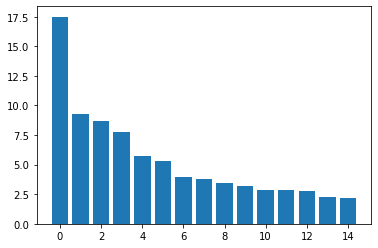

In [68]:
import matplotlib.pyplot as plt

#len(np.sort(abs(el_net.coef_))[::-1]
plt.bar(np.arange(0, 15), percents[:15], align='center')

np.sum(percents[:15])

In [69]:
#Random Forest Classifier for Feature Selection

#from sklearn.model_selection import GridSearchCV

#parameters = {
    #"n_estimators":[5,10,50,100,250],
    #"max_depth":[2,4,8,16,32,None]
    
#}

#X = df_init_6.loc[:, df_init_6.columns != response]
#y = df_init_6[response]

#Scale Training Data
#scaler = preprocessing.StandardScaler().fit(X)
#X_scaled = scaler.transform(X)

#clf = RandomForestClassifier()

#cv = GridSearchCV(clf,parameters,cv=5).fit(X_scaled,y)

# visualize feature importance

#plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')


#df_init_8 = df_init_6[feat_importances.nlargest(30).index]
#feat_importances.nlargest(30).index
#df_init_7 = df_init_6[feat_importances.nlargest(30)] 

In [70]:
#cv.best_estimator_

In [71]:
#from boruta import BorutaPy

# define Boruta feature selection method
#feat_selector = BorutaPy(cv.best_estimator_, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
#feat_selector.fit(np.array(X_scaled), np.array(y))

# check selected features
#feat_selector.support_

# check ranking of features

In [72]:
#mask = [any(tup) for tup in zip(feat_selector.support_,feat_selector.support_weak_)]

#mask = [i for i, x in enumerate(mask) if not x]

#df_init_8 = df_init_6.drop(df_init_6.columns[mask],axis = 1)

#df_init_8

In [73]:
df_init_7.groupby('MCQ220').count()

,INQ030,AUQ054,KIQ005,HUQ051,MCQ371D,MCQ560,HUQ071,OHQ033,MCQ092,DPQ040,OHQ870,PUQ110,SMQ020,INDFMMPI
MCQ220,,,,,,,,,,,,,,
1.0,516,516,516,516,516,516,516,516,516,516,516,516,516,516
2.0,4501,4501,4501,4501,4501,4501,4501,4501,4501,4501,4501,4501,4501,4501


In [80]:
#Filter Values for Even Number of Rows and Columns

# SMOTE Sampling/ ADASYN Sampling 

#Filter Dataset to Remove 9 and get even sampling of data

df_init_8 = df_init_7

df_init_8[response] = y

df_init_8 = df_init_8[df_init_8.MCQ220 != 9]

df_init_8 = df_init_8.groupby('MCQ220').sample(n= 516)

# Drop Datasets After Observations 

df_init_8 = df_init_8.drop(['OHQ870', 'INDFMMPI'], axis=1)

df_init_8

<ipython-input-80-6c3fc49aa8da>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init_8[response] = y


,INQ030,AUQ054,KIQ005,HUQ051,MCQ371D,MCQ560,HUQ071,OHQ033,MCQ092,DPQ040,MCQ220,PUQ110,SMQ020
2606,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,1.0,2.0,2.0
15417,1.0,4.0,5.0,4.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0
7614,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,0.0,1.0,9.0,2.0
10180,1.0,1.0,1.0,6.0,1.0,2.0,2.0,4.0,1.0,1.0,1.0,2.0,2.0
16764,1.0,5.0,1.0,3.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,1.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,0.0,2.0,2.0,1.0
10453,1.0,3.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0
11187,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,2.0,2.0,2.0
456,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,0.0,2.0,2.0,1.0


C:\Users\nlahanis\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


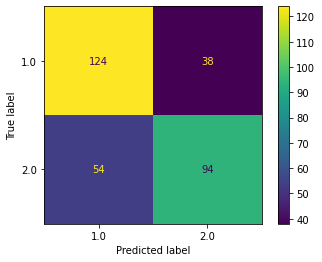

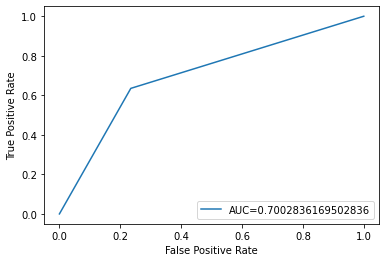

In [158]:
# LOGISTIC REGRESSION MODEL
X = df_init_8.loc[:, df_init_8.columns != response]
y = df_init_8[response]


accuracy = []
precision = []
aucision = []
precision = []
medians = []


#Split Data into Train (80%) and Test (20%)
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Scale Training Data
scaler = preprocessing.StandardScaler().fit(X)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)
    
l = np.linspace(.001, 1.0, num =20)
    
logr = LogisticRegressionCV(solver = 'saga', penalty = 'elasticnet', l1_ratios = l).fit(X_train_scaled,y_train)

#logr = LogisticRegressionCV(solver = 'lbfgs').fit(X_train_scaled,y_train)

#Change Threshold to be .675

prob_predictions = logr.predict_proba(X_test)
prob_predictions = [item[0] for item in prob_predictions]
predictions = [1 if i > .55 else 2 for i in prob_predictions]
    
med = np.median(prob_predictions)
medians.append(med)

#Print Accuracy and Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, labels=logr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logr.classes_)
    
#accuracy_score, roc_auc_score, precision_score

    
#auc = roc_auc_score(y_test, predictions)
#aucision.append(auc)
    
#prec = precision_score(y_test, predictions)
#precision.append(prec)

disp.plot()
plt.show()

#plt.plot(accuracy)
#plt.plot(aucision)
#plt.plot(precision)
    

#define metrics

#AUC Curve
auc_pred = [0 if i==1 else 1 for i in predictions]
auc_y = [0 if i==1 else 1 for i in y_test]
fpr, tpr, _ = metrics.roc_curve(auc_y,  auc_pred)
auc = metrics.roc_auc_score(auc_y, auc_pred)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
     
#Investigate Bias-Variance Tradeoff

Text(0, 0.5, 'pc2')

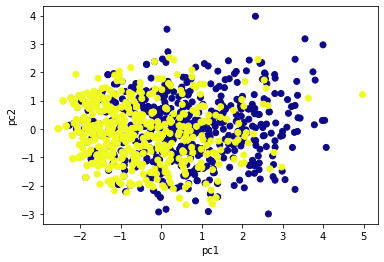

In [159]:
from sklearn.decomposition import PCA

X = df_init_8.loc[:, df_init_8.columns != response]
y = df_init_8[response]

#Scale Data
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

principal=PCA(n_components=2)
principal.fit(X_scaled)
x=principal.transform(X_scaled)

plt.scatter(x[:,0],x[:,1],c=df_init_8['MCQ220'],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

Text(0.5, 0, 'PC3')

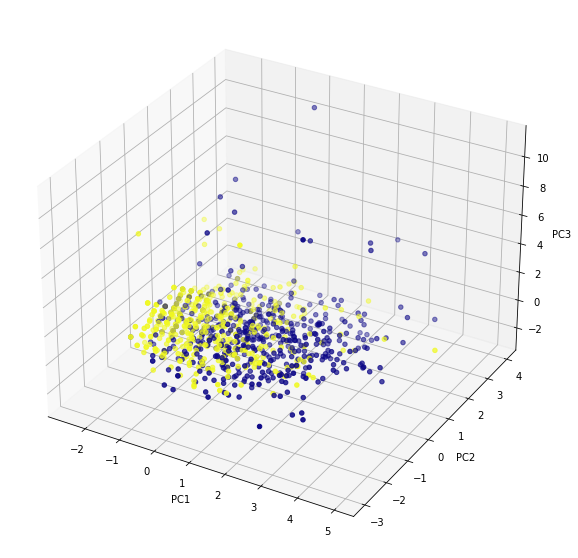

In [160]:
# import relevant libraries for 3d graph
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

principal=PCA(n_components=3)
principal.fit(X_scaled)
x=principal.transform(X_scaled)
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=df_init_8['MCQ220'],cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

In [161]:
np.median(accuracy)

C:\Users\nlahanis\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nlahanis\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [162]:
np.median(prob_predictions)

0.6251645184273498

In [169]:
import pickle 

#Store Median Model Values
medians = np.array(X.median(axis=0))
median_file = "cancer_gen_pop.pickle"

# save median values
pickle.dump(medians, open(median_file, "wb"))

#Store Scaler
scale_file = "cancer_scale.pickle"

# save scale
pickle.dump(scaler, open(scale_file, "wb"))

#Store Logistic Regression Model
stor_file = "cancer_pred.pickle"

# save model
pickle.dump(logr, open(stor_file, "wb"))

[0.7319511921587548]


array([1., 2., 1., 2., 1., 2., 2., 1., 2., 0., 2., 2.])

In [166]:
scaler.transform(medians)

C:\Users\nlahanis\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[1. 2. 1. 2. 1. 2. 2. 1. 2. 0. 2. 2.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.